In [ ]:
from jaxgym.ode import odedopri,  electron_equation_of_motion_DA
from jaxgym.field import schiske_lens_expansion_xyz, obtain_first_order_electrostatic_lens_properties
import jaxgym.components as comp
from jaxgym.ray import Ray
from jaxgym.run import run_to_end, calculate_derivatives
from jaxgym.taylor import polynomial_dict, order_indices, poly_dict_to_sympy_expr

import jax
import jax.numpy as jnp
import optimistix as optx

from scipy.constants import h as h_planck, e, m_e
from daceypy import array, DA
import sympy as sp
import os

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_LIMIT_MB"] = "400"

In [7]:
X, Y, Z = sp.symbols('X Y Z')

scale = 1 #set to mm scale
# Set Parameters for Schiske Electrostatic Lens
# Define lens parameters

z_init = -0.020*scale  # Convert m to um units
a = 0.0004*scale  # Convert m to um units
phi_0 = 1  # Volts
k = 0.40**(1/2)  # Unitless

(
    phi_expansion_symbolic,
    E_lambda, phi_lambda,
    phi_lambda_axial,
    phi_lambda_prime,
    phi_lambda_double_prime,
    phi_lambda_quadruple_prime,
    phi_lambda_sextuple_prime
) = schiske_lens_expansion_xyz(X, Y, Z, phi_0, a, k)

wavelength = h_planck/(2*abs(e)*m_e*phi_lambda_axial(z_init))**(1/2)*scale

In [8]:
z_pos, g, g_, h, h_, mag_real, z_image, z_focal_real, z_focal_asymp, z_pi = obtain_first_order_electrostatic_lens_properties(
    z_init, phi_lambda_axial, phi_lambda_prime, phi_lambda_double_prime, z_sampling=1000)

In [9]:
order = 4

DA.init(order, 5)

# Set initial conditions. It does not matter that the slope and position are 0.
x0 = 0.
y0 = 0.
x0_slope = 0.0
y0_slope = 0.0
opl = 0.

u0 = 1.0

x = array([x0 + DA(1), y0 + DA(2), x0_slope + DA(3), y0_slope + DA(4), opl + DA(5)])

# solve the equation of motion via the differential algebra method, which delivers the solution as a taylor expansion
with DA.cache_manager():
    zf, x_f = odedopri(electron_equation_of_motion_DA, z_init,
                        x,  z_image,  1e-1, 10000, 1e-15,  
                        int(1e5), (phi_lambda, E_lambda, u0))

In [12]:
z_init = jnp.array(z_init)
z_image = jnp.array(z_image)

PointSource = comp.InputPlane(z=z_init)
ElectrostaticLens = comp.ODE(z=z_init, z_end=z_image, phi_lambda=phi_lambda, E_lambda=E_lambda)
Detector = comp.Detector(z=z_image, det_pixel_size=(55e-6, 55e-6), det_shape = (256, 256))
model = [PointSource, ElectrostaticLens, Detector]

ray = Ray(0., 0., 0., 0., 0., z_init, 0.0)
ray_out = run_to_end(ray, model)

derivatives = calculate_derivatives(ray, model, order)

In [13]:
selected_vars = ['x', 'y', 'dx', 'dy', 'pathlength']
multi_indices = order_indices(order, n_vars=len(selected_vars))

In [14]:
poly_dict = polynomial_dict(derivatives, selected_vars, multi_indices[1:])

In [25]:
x_var, y_var, dx_var, dy_var, opl_var = sp.symbols('x y x_p y_p S')
polynomials = poly_dict_to_sympy_expr(poly_dict, selected_vars, sym_vars=[x_var, y_var, dx_var, dy_var, opl_var])

In [40]:
print(polynomials['x'])

-23069095.9559176*x**3 - 1384309.95856281*x**2*x_p - 27693.377447592*x*x_p**2 - 23069095.9559176*x*y**2 - 922797.959323843*x*y*y_p - 9231.12581594355*x*y_p**2 - 0.883574443486705*x - 184.696365322543*x_p**3 - 461511.999238967*x_p*y**2 - 18462.2516316485*x_p*y*y_p - 184.696365322543*x_p*y_p**2 - 3.98300099499482e-14*x_p


In [ ]:
jax_poly_x = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['x'], modules='jax')
jax_poly_y = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['y'], modules='jax')
jax_poly_opl = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['pathlength'], modules='jax')

In [ ]:
detector_coords = Detector.get_coords()

In [ ]:
def f(params, args):
    dx, dy = params[0], params[1]
    x_in, y_in = args[0], args[1]
    x_out, y_out = args[2], args[3]
    res_x = jax_poly_x(x_in, y_in, dx, dy) - x_out 
    res_y = jax_poly_y(y_in, y_in, dx, dy) - y_out
    return res_x, res_y

solver = optx.Newton(rtol=1e-8, atol=1e-8)
params = jnp.array([0.0, 0.0])
args = jnp.array([0.0, 0.0, 1e-5, 1e-5])
sol = optx.root_find(f, solver, params, args)

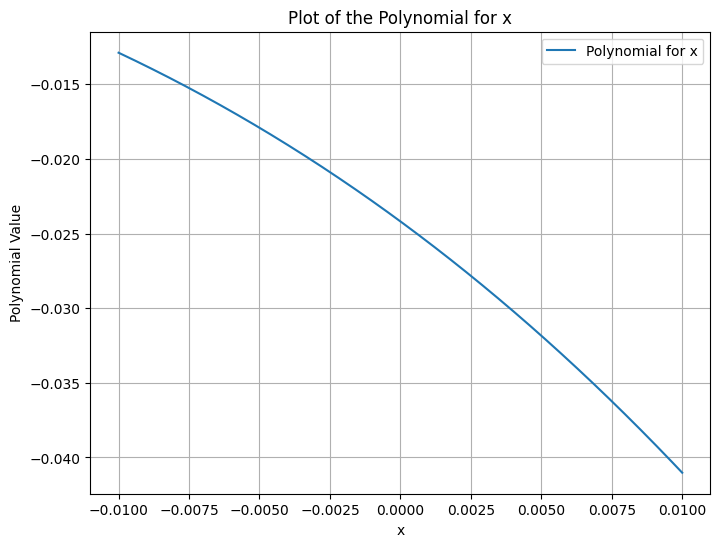

In [26]:
import numpy as np

import matplotlib.pyplot as plt

# Substitute dy_var to 0.0 and evaluate the polynomial
polynomial_x = polynomials['x'].subs({x_var: 1e-3, y_var: 1e-4, dy_var: 0.0})

# Convert the polynomial to a lambda function for numerical evaluation
polynomial_x_func = sp.lambdify(dx_var, polynomial_x, "numpy")

# Generate x values and evaluate the polynomial
x_values = np.linspace(-1e-2, 1e-2, 500)
y_values = polynomial_x_func(x_values)

# Plot the polynomial
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label="Polynomial for x")
plt.xlabel("x")
plt.ylabel("Polynomial Value")
plt.title("Plot of the Polynomial for x")
plt.legend()
plt.grid()
plt.show()

In [ ]:
lambda_polynomials = {
    key: sp.lambdify((x_var, y_var, dx_var, dy_var, opl_var), expr, "numpy")
    for key, expr in polynomials.items()
}



In [10]:
var = 'pathlength'

if var == 'x':
    var_idx = 0
elif var == 'y':
    var_idx = 1
elif var == 'dx':
    var_idx = 2
elif var == 'dy':
    var_idx = 3
elif var == 'pathlength':
    var_idx = 4
else:
    raise ValueError(f"Unknown variable: {var}")

header = f"{'I':>6}  {'COEFFICIENT':>3}   {'ORDER':>16} {'EXPONENTS':>4}"
const = f"{1:6d}   {getattr(ray_out, var): .16e}   {0} {'  0  0  0  0  0':15s}"

print_jax = [header, const]
for idx, entry in enumerate(multi_index_array[var]):
    exponents = tuple(map(int, entry[:-1]))
    coeff = entry[-1]
    total_order = sum(exponents)
    exponents_str = " ".join(f"{e:2d}" for e in exponents)
    print_jax.append(f"{idx:6d}   {coeff: .16e}   {total_order}  {exponents_str}")
print_jax.append('------------------------------------------------')


header = f"{'I':>6}  {'COEFFICIENT':>3}   {'ORDER':>16} {'EXPONENTS':>4}"
const = f"{1:6d}   {x_f[var_idx].getCoefficient([0, 0]): .16e}   {0} {'  0  0  0  0  0':15s}"

print_daceypy = [header, const]

for idx, entry in enumerate(multi_index_array[var]):
    exponents = tuple(map(int, entry[:-1]))
    coeff = x_f[var_idx].getCoefficient(list(exponents))
    total_order = sum(exponents)
    exponents_str = " ".join(f"{e:2d}" for e in exponents)
    print_daceypy.append(f"{idx:6d}   {coeff: .16e}   {total_order}  {exponents_str}")
print_daceypy.append('------------------------------------------------')

# Print the two blocks side by side
for left, right in zip(print_jax, print_daceypy):
    print(f"{left:<60} {right}")


NameError: name 'multi_index_array' is not defined